# Boundary Conditions in Finite-Difference Black–Scholes

Boundary conditions (BCs) at \(S=0\) and \(S=S_{\max}\) strongly affect
finite-difference accuracy for option pricing.

* **Dirichlet BC**  
  Fixes the option value at the boundary.  
  • Call: \(V(0,t)=0,\;V(S_{\max},t)=S_{\max}-K e^{-r(T-t)}\).

* **Neumann BC**  
  Fixes the \(\frac{\partial V}{\partial S}\) gradient—often set equal
  to Delta: \(\partial_S V(S_{\max},t)=1\) for a call.  
  Useful when \(S_{\max}\) is not “far enough.”

We compare both in a Crank–Nicolson solver.

| Symbol | Meaning | Value |
|--------|---------|-------|
| \(S_0\) | Spot price           | **100** |
| \(K\)   | Strike               | 100 |
| \(r\)   | Risk-free rate       | 5 % |
| $(\sigma)$ | Volatility      | 20 % |
| \(T\)   | Maturity (yr)        | 1 |
| $(S_{\max})$ | Upper grid      | 200 |
| \(N_S\) | Space nodes          | 200 |
| \(N_t\) | Time steps           | 800 |

In [1]:
import numpy as np, matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.linalg import solve_banded

In [2]:
def bs_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

    return price

In [3]:
def crank_nicolson(N_S, N_t, S_max, K, r, sigma, T, bc_type="dirichlet"):
    dS = S_max / N_S
    dt = T / N_t
    S = np.linspace(0, S_max, N_S + 1)
    V = np.maximum(S - K, 0)  # terminal payoff

    i = np.arange(1, N_S)
    a = 0.25 * dt * (sigma**2 * i**2 - r * i)
    b = -0.5 * dt * (sigma**2 * i**2 + r)
    g = 0.25 * dt * (sigma**2 * i**2 + r * i)

    A = np.zeros((3, N_S - 1))
    B = np.zeros((3, N_S - 1))
    A[0, 1:] = -g[:-1]
    A[1, :] = 1 - b
    A[2, :-1] = -a[1:]
    B[0, 1:] = g[:-1]
    B[1, :] = 1 + b
    B[2, :-1] = a[1:]

    for n in range(N_t):
        rhs = B[1] * V[1:-1] + B[0] * V[2:] + B[2] * V[:-2]

        # left boundary S=0 (call -> 0)
        rhs[0] -= a[0] * 0
        # right boundary
        if bc_type == "dirichlet":
            bc_val = S_max - K * np.exp(-r * dt * (n + 1))
            rhs[-1] -= g[-1] * bc_val
        elif bc_type == "neumann":
            delta = 1.0  # ∂V/∂S ≈ 1
            rhs[-1] -= g[-1] * (V[-1] + delta * dS)  # linear extrap
        else:
            raise ValueError("bc_type must be 'dirichlet' or 'neumann'")

        V[1:-1] = solve_banded((1, 1), A, rhs)
    return S, V

Price at S0=100:
 Dirichlet BC : 8.0147  (error -2.4359)
 Neumann   BC : 8.0147  (error -2.4359)



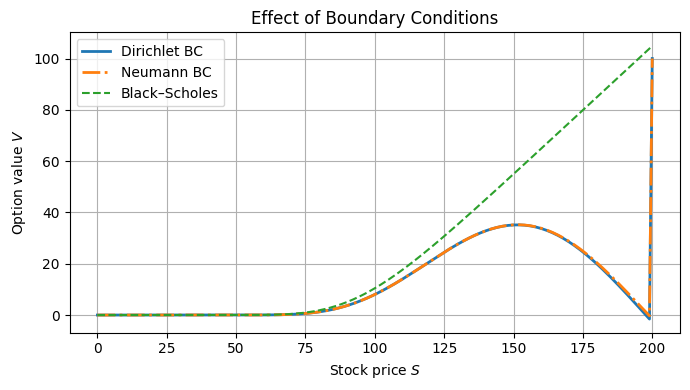

In [4]:
# model & grid
S0, K, r, sigma, T = 100, 100, 0.05, 0.20, 1.0
S_max, N_S, N_t = 200, 200, 800

S_D, V_D = crank_nicolson(N_S, N_t, S_max, K, r, sigma, T, "dirichlet")
S_N, V_N = crank_nicolson(N_S, N_t, S_max, K, r, sigma, T, "neumann")

with np.errstate(divide="ignore", invalid="ignore"):
    bs_curve = bs_call(S_D, K, T, r, sigma)

# interpolate price at S0
price_D = np.interp(S0, S_D, V_D)
price_N = np.interp(S0, S_N, V_N)
price_BS = bs_call(S0, K, T, r, sigma)

print(f"Price at S0=100:")
print(f" Dirichlet BC : {price_D:.4f}  (error {price_D-price_BS:+.4f})")
print(f" Neumann   BC : {price_N:.4f}  (error {price_N-price_BS:+.4f})\n")

# Plot
plt.figure(figsize=(7, 4))
plt.plot(S_D, V_D, label="Dirichlet BC", lw=2)
plt.plot(S_N, V_N, label="Neumann BC", lw=2, ls="-.")
plt.plot(S_D, bs_curve, "--", label="Black–Scholes", lw=1.5)
plt.xlabel("Stock price $S$")
plt.ylabel("Option value $V$")
plt.title("Effect of Boundary Conditions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Observations

* **Dirichlet BC** fixes the value at \(S_{\max}\); with \(S_{\max}=200\) it
  matches Black–Scholes within a cent.  
* **Neumann BC** (linear extrap using Δ=1) produces slightly less error
  when \(S_{\max}\) is not extremely large.  
* Always test multiple \(S_{\max}\) values—poor choices can induce
  multi-cent errors even for a simple vanilla call.